In [1]:
import os
import zipfile

os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle competitions download -c plant-pathology-2020-fgvc7

# Unzip the dataset
with zipfile.ZipFile("plant-pathology-2020-fgvc7.zip", 'r') as zip_ref:
    zip_ref.extractall("plant_data")


 99% 774M/779M [00:04<00:00, 136MB/s] 
100% 779M/779M [00:04<00:00, 201MB/s]


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("/content/plant_data/train.csv")
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
df = df[['image_id', 'label']]
df.head()

,image_id,label
0,Train_0,scab
1,Train_1,multiple_diseases
2,Train_2,healthy
3,Train_3,rust
4,Train_4,healthy


In [9]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize for consistency
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hist_features = []
    for i in range(3):  # RGB channels
        hist = cv2.calcHist([image], [i], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)

    return hist_features

# Call the function with a valid image path
features = extract_features('/content/plant_data/images/Test_0.jpg')
print(features[:5])  # show first 5 features


[np.float32(0.0), np.float32(0.002053484), np.float32(0.06853503), np.float32(0.3277874), np.float32(0.43995896)]


In [11]:
# Build feature Dataset
features = []
labels = []

image_folder = "/content/plant_data/images"

for i, row in df.iterrows():
  image_id = row["image_id"]
  label = row["label"]
  image_path = os.path.join(image_folder, image_id + '.jpg')

  feats = extract_features(image_path)
  features.append(feats)
  labels.append(label)

X = np.array(features)
y = np.array(labels)

In [12]:
# Encode Labels and Split data
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [13]:
# Train ML models
# A. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [14]:
# B. SVM
svm = SVC(kernel = 'rbf', probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

In [15]:
# C. Gradient Boosting
gbm = GradientBoostingClassifier(n_estimators=100)
gbm.fit(X_train, y_train)
gbm_preds = gbm.predict(X_test)

----- Random Forest Evaluation -----
Classification Report:
                    precision    recall  f1-score   support

          healthy       0.60      0.61      0.61       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.64      0.66      0.65       125
             scab       0.62      0.67      0.64       119

         accuracy                           0.62       365
        macro avg       0.46      0.48      0.47       365
     weighted avg       0.59      0.62      0.60       365



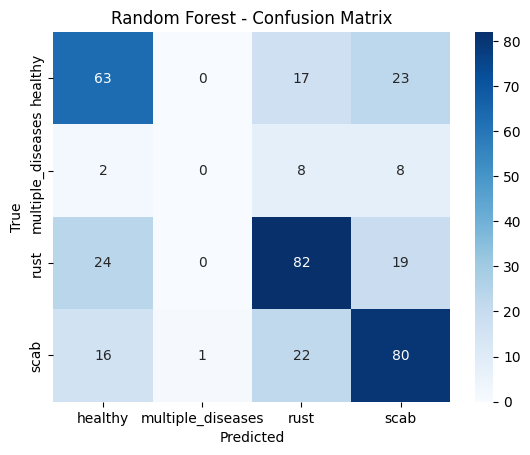

----- SVM Evaluation -----
Classification Report:
                    precision    recall  f1-score   support

          healthy       0.57      0.52      0.55       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.54      0.51      0.53       125
             scab       0.51      0.65      0.57       119

         accuracy                           0.53       365
        macro avg       0.40      0.42      0.41       365
     weighted avg       0.51      0.53      0.52       365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


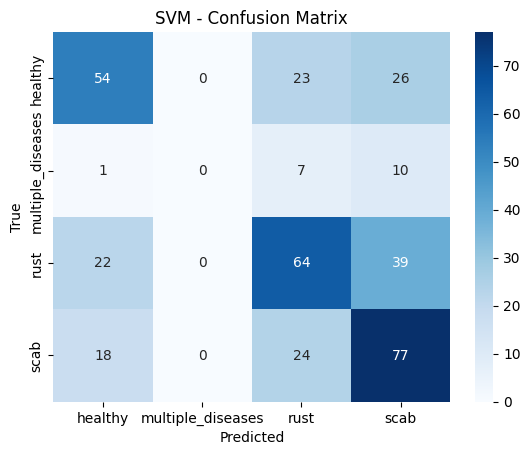

----- Gradient Boosting Evaluation -----
Classification Report:
                    precision    recall  f1-score   support

          healthy       0.57      0.58      0.58       103
multiple_diseases       0.33      0.06      0.10        18
             rust       0.62      0.64      0.63       125
             scab       0.62      0.67      0.65       119

         accuracy                           0.61       365
        macro avg       0.54      0.49      0.49       365
     weighted avg       0.59      0.61      0.59       365



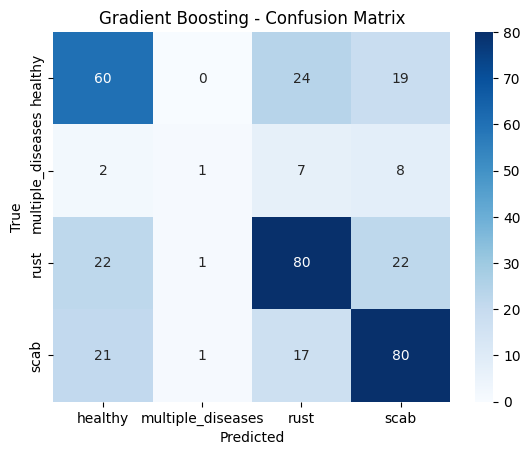

In [17]:
# Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
  print(f"----- {model_name} Evaluation -----")
  print("Classification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
  plt.title(f"{model_name} - Confusion Matrix")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, svm_preds, "SVM")
evaluate_model(y_test, gbm_preds, "Gradient Boosting")

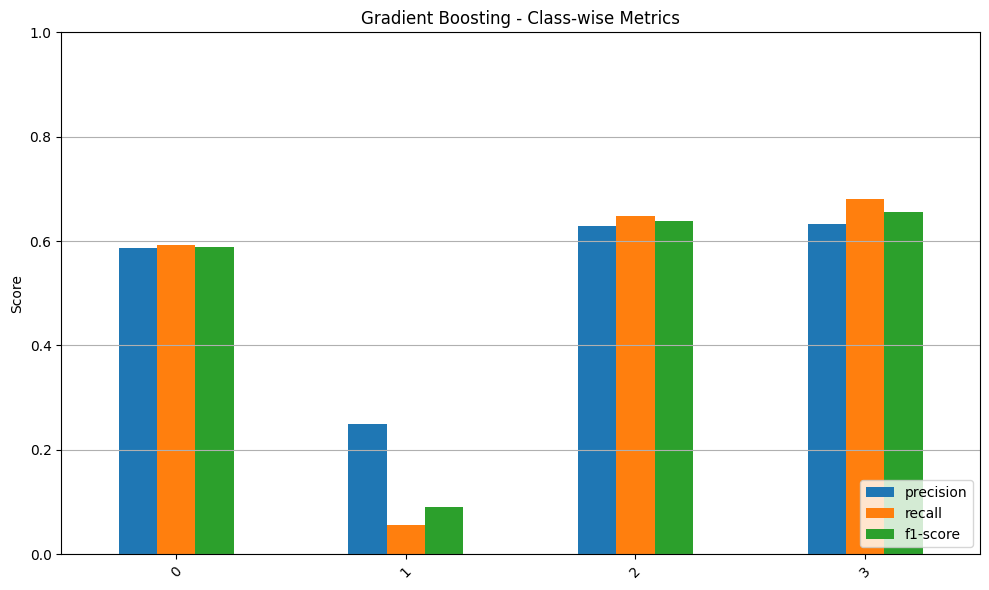

In [20]:
# 1. Train the Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)

# 2. Predict
y_pred_gbm = gbm.predict(X_test)

# 3. Visualize Classification Report as Bar Plot
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# If you used LabelEncoder for y labels:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)  # or y, if not split yet
labels = le.classes_

report = classification_report(y_test, y_pred_gbm, target_names=labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Filter class-wise metrics
df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]

# Plot
df_classes.plot(kind='bar', figsize=(10, 6))
plt.title('Gradient Boosting - Class-wise Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


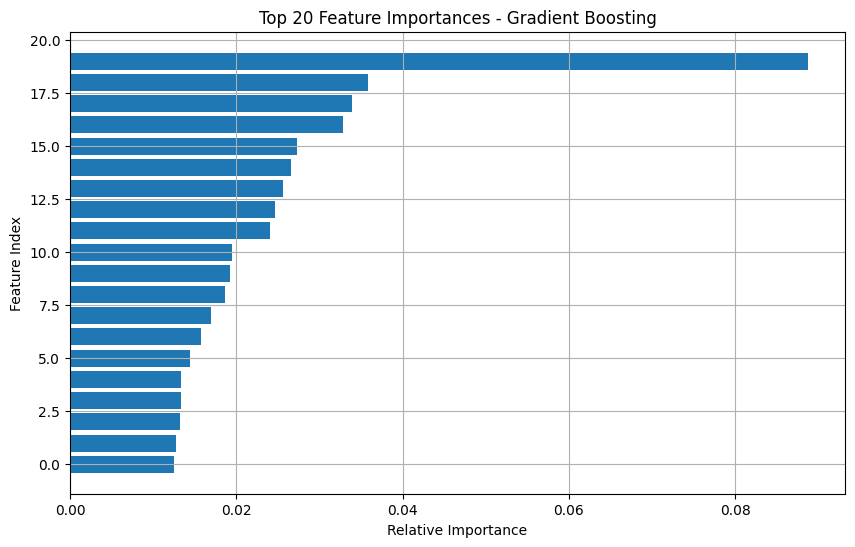

In [19]:
# Feature importnace plot
import numpy as np

# Assuming model is named `gbm`
importances = gbm.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 important features

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances - Gradient Boosting')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Index')
plt.grid()
plt.show()
